## NYC Bike Share Project

Predicting citi bike demand based off of points of interest in New York City.

Inspired by Climate Change AI's 'Predicting Mobility Demand From Urban Features' Tutorial

In [157]:
import geopandas as gpd
import matplotlib.pyplot as plt
from shapely.geometry import Point, Polygon, MultiPolygon
import numpy as np
import seaborn as sns
import os
from sklearn.linear_model import LinearRegression
from scipy.stats import gaussian_kde
import shutil
from geodatasets import get_path

In [158]:
#read shape data of the five NYC boroughs
path_to_data = get_path('nybb')
gdf = gpd.read_file(path_to_data)
gdf

,BoroCode,BoroName,Shape_Leng,Shape_Area,geometry
0,5,Staten Island,330470.010332,1.623820e+09,"MULTIPOLYGON (((970217.022 145643.332, 970227...."
1,4,Queens,896344.047763,3.045213e+09,"MULTIPOLYGON (((1029606.077 156073.814, 102957..."
2,3,Brooklyn,741080.523166,1.937479e+09,"MULTIPOLYGON (((1021176.479 151374.797, 102100..."
3,1,Manhattan,359299.096471,6.364715e+08,"MULTIPOLYGON (((981219.056 188655.316, 980940...."
4,2,Bronx,464392.991824,1.186925e+09,"MULTIPOLYGON (((1012821.806 229228.265, 101278..."


In [159]:
gdf = gdf.set_index('BoroName')
gdf

,BoroCode,Shape_Leng,Shape_Area,geometry
BoroName,,,,
Staten Island,5,330470.010332,1.623820e+09,"MULTIPOLYGON (((970217.022 145643.332, 970227...."
Queens,4,896344.047763,3.045213e+09,"MULTIPOLYGON (((1029606.077 156073.814, 102957..."
Brooklyn,3,741080.523166,1.937479e+09,"MULTIPOLYGON (((1021176.479 151374.797, 102100..."
Manhattan,1,359299.096471,6.364715e+08,"MULTIPOLYGON (((981219.056 188655.316, 980940...."
Bronx,2,464392.991824,1.186925e+09,"MULTIPOLYGON (((1012821.806 229228.265, 101278..."


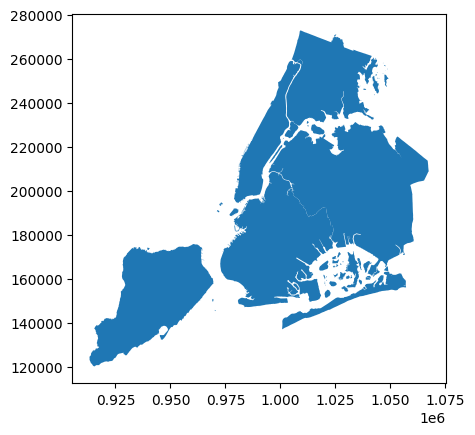

In [160]:
gdf.plot() #We now have a map of New York City to visualize our data.
plt.show()

In [161]:
gdf.bounds

,minx,miny,maxx,maxy
BoroName,,,,
Staten Island,9.131751e+05,120121.881254,9.705701e+05,175708.962036
Queens,9.946086e+05,136681.776184,1.067383e+06,231157.996399
Brooklyn,9.726197e+05,146772.031799,1.030453e+06,208564.104004
Manhattan,9.710135e+05,188082.322388,1.010066e+06,259547.770386
Bronx,1.002623e+06,225426.884583,1.049167e+06,272844.293640


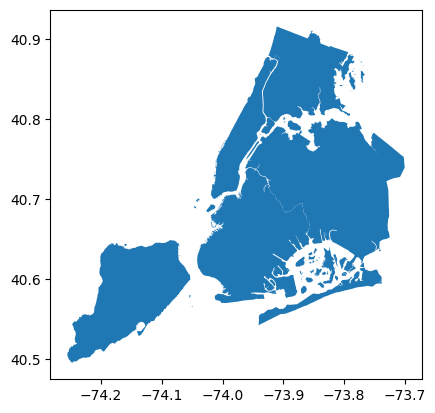

In [162]:
gdf = gdf.to_crs(4326) #change coordinate reference system to latitude and longitude
gdf.plot()
plt.show()

In [163]:
import pandas as pd

In [164]:
city_bike_data = pd.read_csv('201306-citibike-tripdata.csv')

In [165]:
city_bike_data.dropna(inplace=True)

In [166]:
city_bike_data.head()

,tripduration,starttime,stoptime,start station id,start station name,start station latitude,start station longitude,end station id,end station name,end station latitude,end station longitude,bikeid,usertype,birth year,gender
0,695,2013-06-01 00:00:01,2013-06-01 00:11:36,444,Broadway & W 24 St,40.742354,-73.989151,434.0,9 Ave & W 18 St,40.743174,-74.003664,19678,Subscriber,1983.0,1
1,693,2013-06-01 00:00:08,2013-06-01 00:11:41,444,Broadway & W 24 St,40.742354,-73.989151,434.0,9 Ave & W 18 St,40.743174,-74.003664,16649,Subscriber,1984.0,1
3,123,2013-06-01 00:01:04,2013-06-01 00:03:07,475,E 15 St & Irving Pl,40.735243,-73.987586,262.0,Washington Park,40.691782,-73.973730,16352,Subscriber,1960.0,1
4,1521,2013-06-01 00:01:22,2013-06-01 00:26:43,2008,Little West St & 1 Pl,40.705693,-74.016777,310.0,State St & Smith St,40.689269,-73.989129,15567,Subscriber,1983.0,1
6,2057,2013-06-01 00:02:33,2013-06-01 00:36:50,285,Broadway & E 14 St,40.734546,-73.990741,532.0,S 5 Pl & S 5 St,40.710451,-73.960876,15693,Subscriber,1991.0,1


In [167]:
city_bike_data.count()

tripduration               326841
starttime                  326841
stoptime                   326841
start station id           326841
start station name         326841
start station latitude     326841
start station longitude    326841
end station id             326841
end station name           326841
end station latitude       326841
end station longitude      326841
bikeid                     326841
usertype                   326841
birth year                 326841
gender                     326841
dtype: int64

In [168]:
print(city_bike_data['start station latitude'].min(),city_bike_data['start station latitude'].max())

40.6466068 40.771522


In [169]:
print(city_bike_data['start station longitude'].min(),city_bike_data['start station longitude'].max())

-74.01713445 -73.9500479759


Data appears to be restricted to manhattan based off of the start and stop latitudes and longitudes.

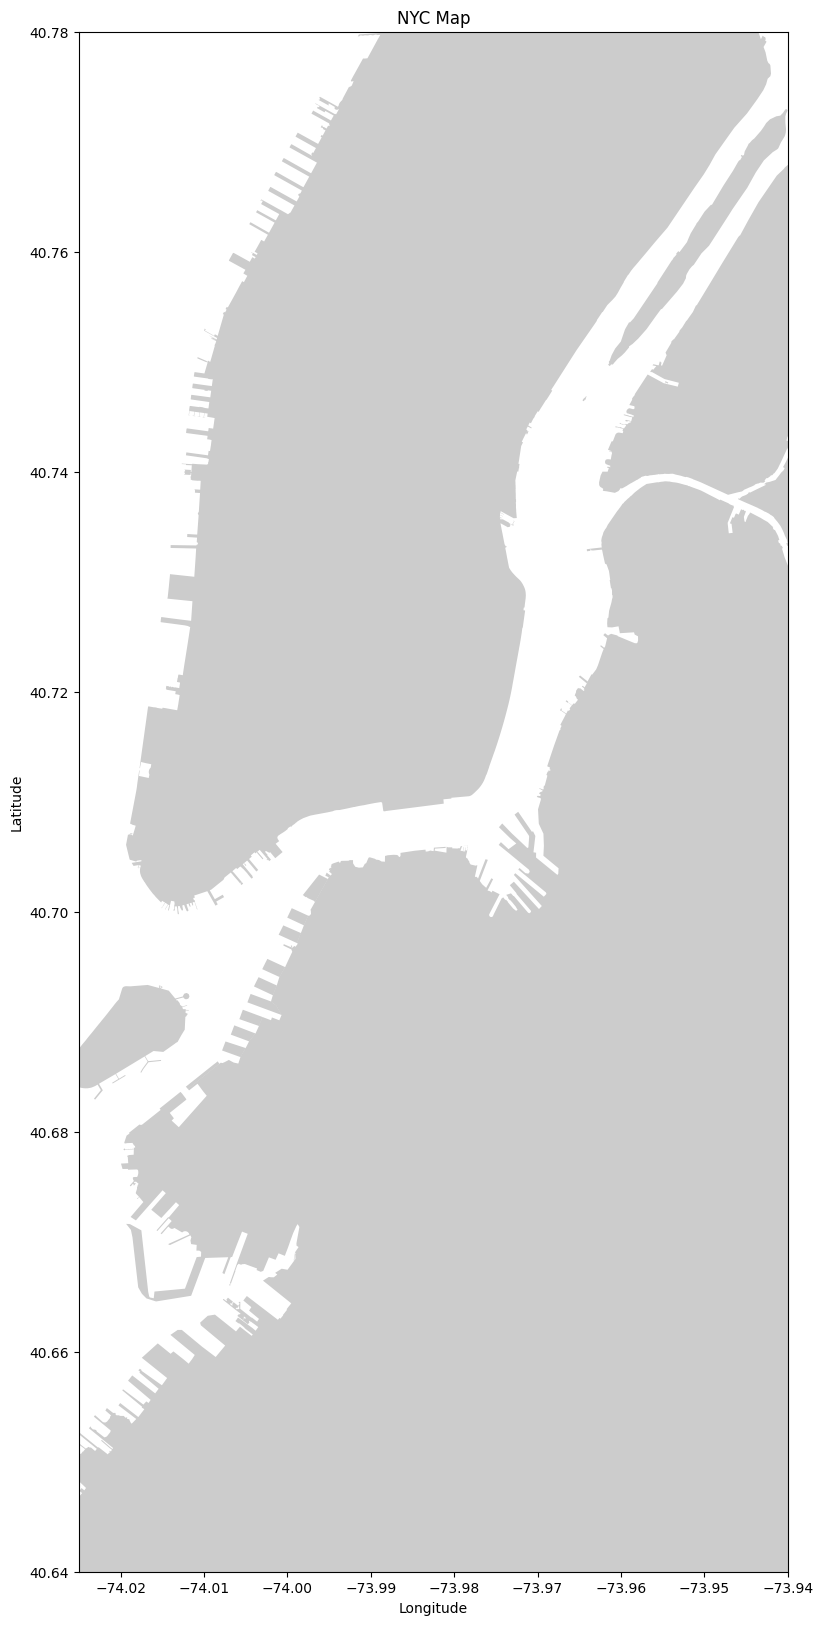

In [170]:

#helper function to plot data points on NYC map
def plot_nyc(data: pd.DataFrame = None, lat_col: str = None, lng_col: str = None, title: str = 'NYC Map', figsize: tuple[int] = (20,20)):
    _ , ax = plt.subplots(figsize=figsize)
    gdf.plot(ax=ax, alpha=0.4, color='grey')
    ax.set_xlim(-74.025,-73.94)
    ax.set_ylim(40.64,40.78)

    if lat_col and lng_col:
        start_geometry = [Point(xy) for xy in zip(data[lng_col], data[lat_col])]
        start_gdf = gpd.GeoDataFrame(data, geometry=start_geometry)
        start_gdf.plot(ax=ax, markersize=0.01, color='blue', marker='o')

    
    ax.set_title(title)
    ax.set_xlabel("Longitude")
    ax.set_ylabel("Latitude")

plot_nyc()

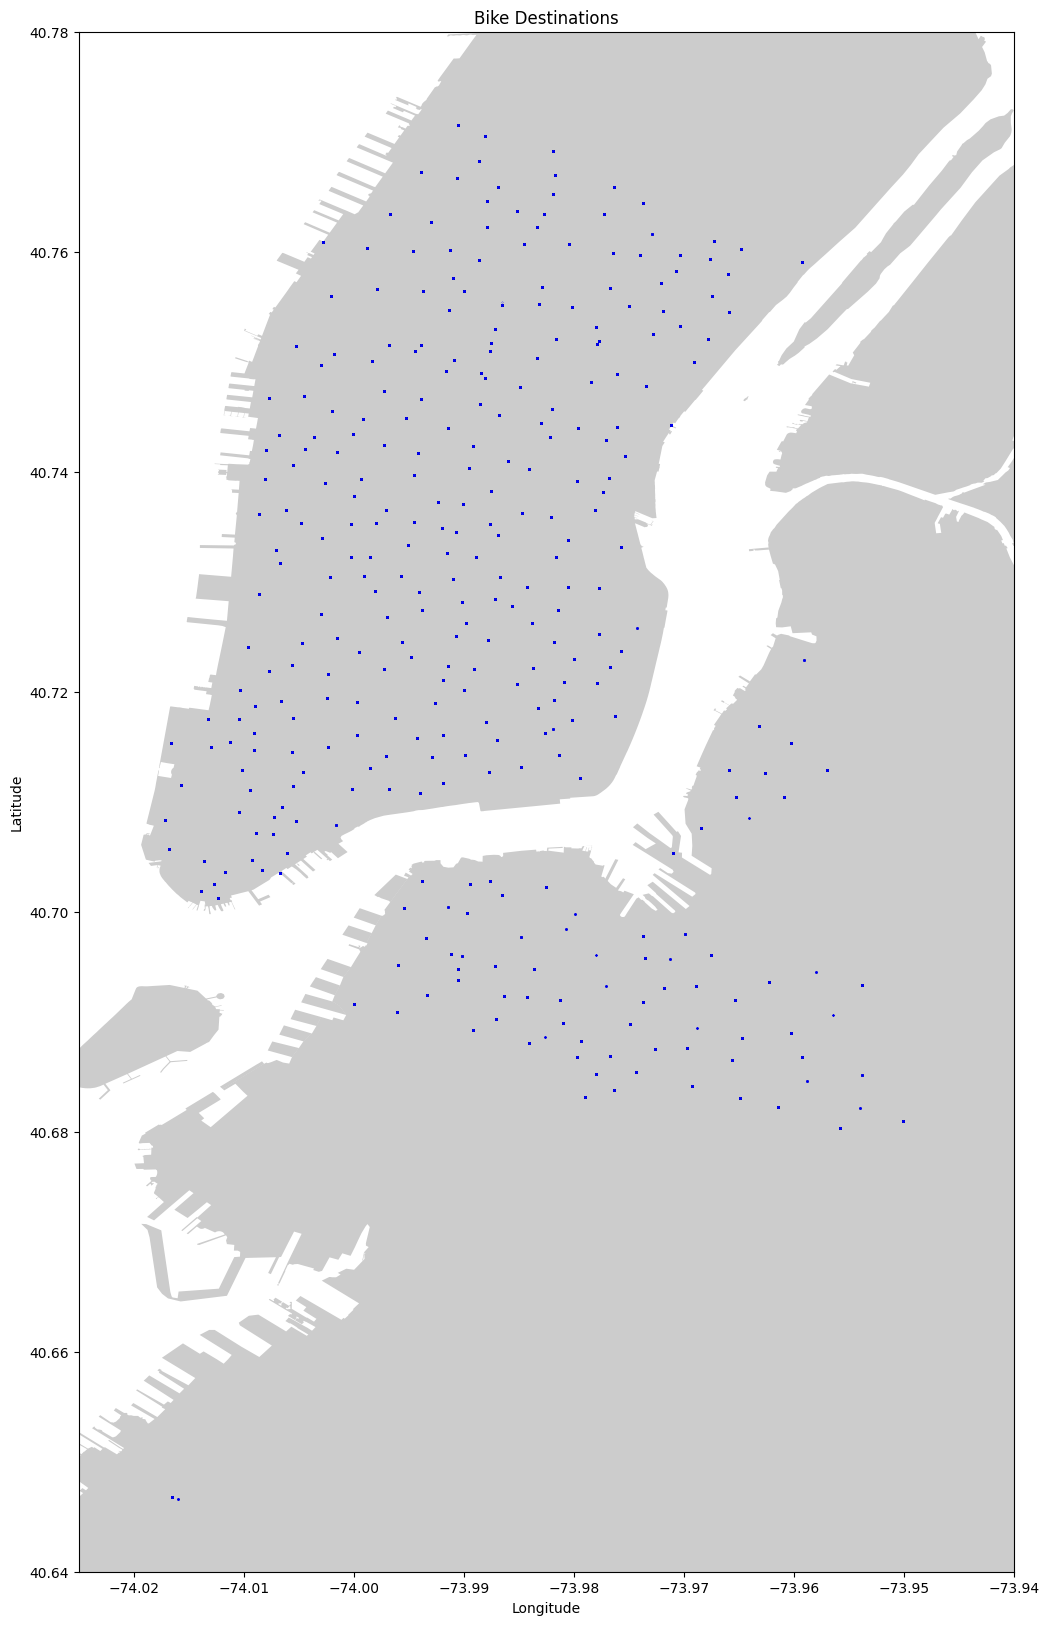

In [176]:
plot_nyc(data= city_bike_data, lat_col="end station latitude",lng_col="end station longitude",title="Bike Destinations")

In [177]:
poi_data = pd.read_csv("Point_Of_Interest.csv") #read our points of interest data
poi_data.head()

,the_geom,SEGMENTID,COMPLEXID,SAFTYPE,SOS,PLACEID,FACI_DOM,BIN,BOROUGH,CREATED,MODIFIED,FACILITY_T,SOURCE,B7SC,PRI_ADD,NAME
0,POINT (-74.00701717096757 40.724634757833414),31895,0,N,1.0,567,9,0,1.0,05/14/2009 12:00:00 AM,11/18/2011 12:00:00 AM,6,DoITT,19743001.0,0,HOLLAND
1,POINT (-73.82661642130311 40.797182526598505),306303,3378,N,2.0,568,8,0,4.0,05/14/2009 12:00:00 AM,01/09/2017 12:00:00 AM,6,DoITT,49731001.0,0,WHITESTONE
2,POINT (-73.99395441100663 40.70384707235758),144842,3960,N,2.0,576,8,0,3.0,05/14/2009 12:00:00 AM,01/22/2018 12:00:00 AM,6,DoITT,39734001.0,0,BROOKLYN
3,POINT (-73.9919414213091 40.70960010711745),162664,0,N,1.0,580,8,0,1.0,05/14/2009 12:00:00 AM,05/11/2011 12:00:00 AM,6,DoITT,19795001.0,0,MANHATTAN
4,POINT (-73.9526609766105 40.73906602249743),157362,0,N,1.0,582,8,0,3.0,05/14/2009 12:00:00 AM,03/03/2017 12:00:00 AM,6,DoITT,39740001.0,0,PULASKI


In [178]:
long = [float(poi_data["the_geom"].loc[i].split()[1].strip("(")) for i in range(len(poi_data))]
lat = [float(poi_data["the_geom"].loc[i].split()[2].strip(")")) for i in range(len(poi_data))]
poi_data["Latitude"] = lat
poi_data["Longitude"] = long

In [179]:
poi_data = poi_data[poi_data["Longitude"] >= -74.025] #restrict data to the area in which bikes are available
poi_data = poi_data[poi_data["Longitude"] <= -73.94]
poi_data = poi_data[poi_data["Latitude"] >= 40.64]
poi_data = poi_data[poi_data["Latitude"] <= 40.78]



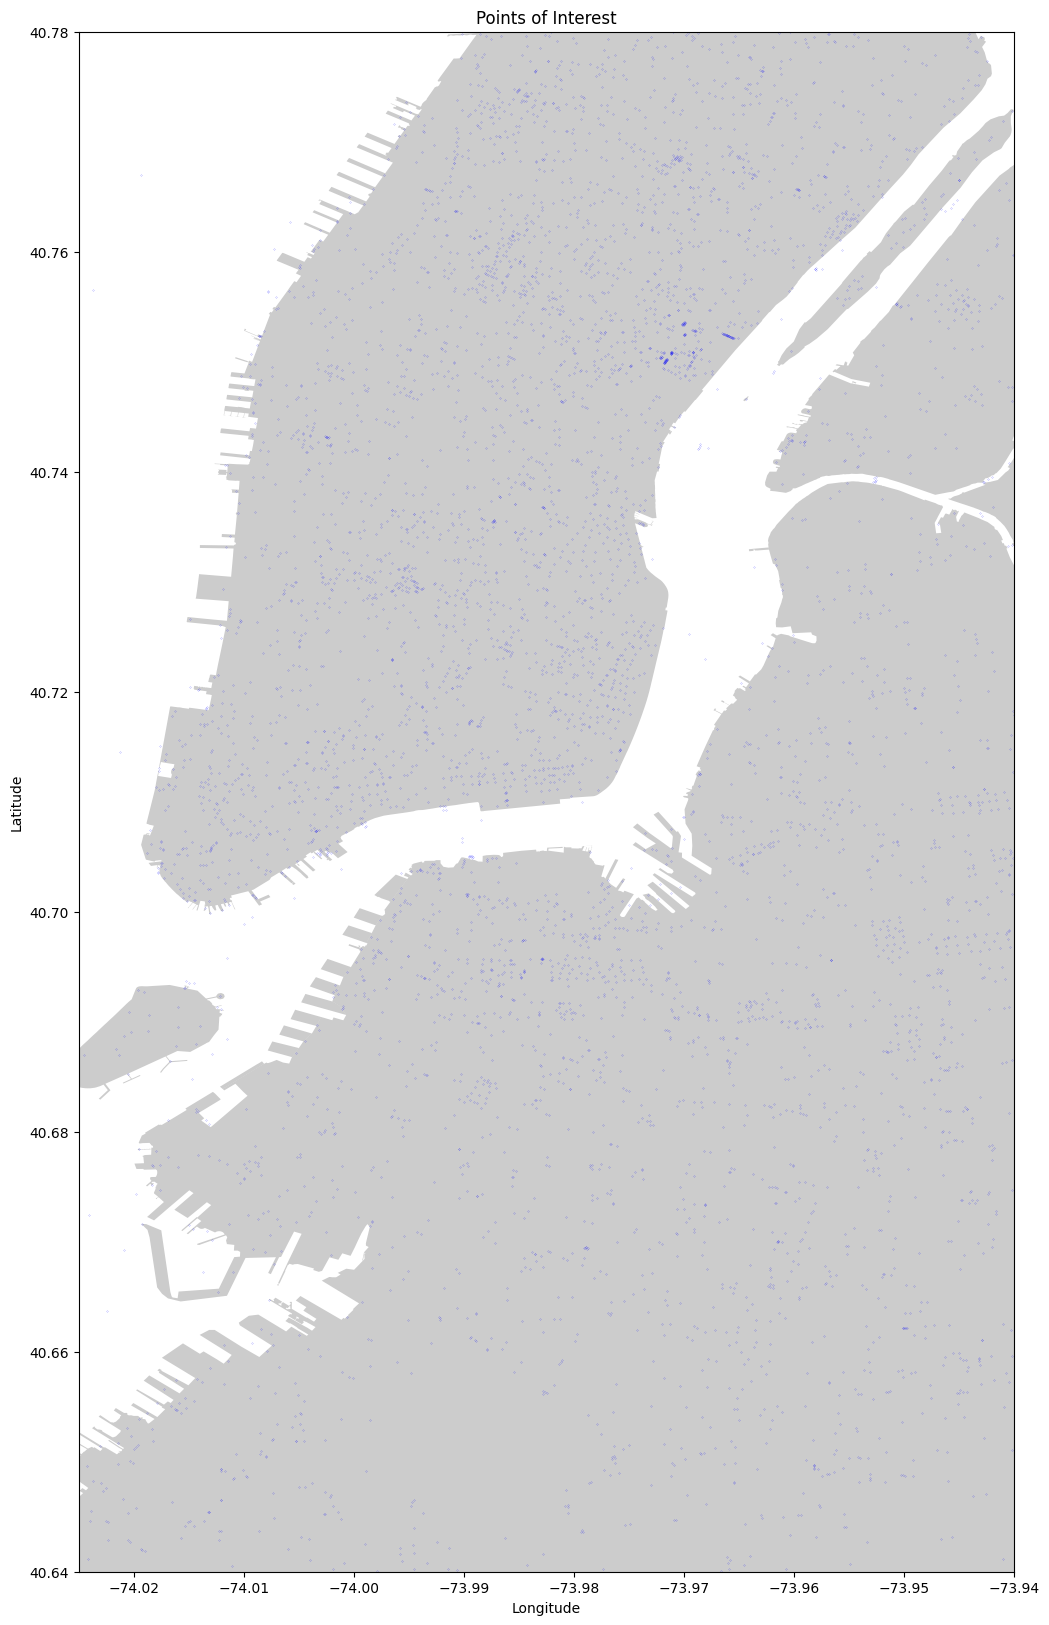

In [180]:
plot_nyc(data=poi_data,lat_col = "Latitude", lng_col = "Longitude",title="Points of Interest")

In [181]:
start_geometry = [Point(xy) for xy in zip(poi_data["Longitude"], poi_data["Latitude"])]
poi_gdf = gpd.GeoDataFrame(poi_data, geometry=start_geometry)

#Prepare directory to save poi geodataframe
compiled_poi_path = '/Users/coledixon/Documents/ML-Projects/Bike_share_project/poi_compiled'

#Delete folder if it already exists
if os.path.exists(compiled_poi_path):
  shutil.rmtree(compiled_poi_path)

os.mkdir(compiled_poi_path)

#Save poi gdf
poi_gdf.to_file(compiled_poi_path + '/compiled.shp', encoding='UTF-8')

In order to better visualize our data, we compute contour gradients to display the densities of data points for both trip destinations and points of interest. We use kernal density estimation to compute these gradients based off of a normal distribution.

In [182]:
#Saves the contours generated by sns.kdeplot as gdfs
def save_density_contours(plot, crs, save_path):
  level_polygons = []

  for i,col  in enumerate(plot.collections):
      paths = []
      # Loop through all polygons that have the same intensity level
      for contour in col.get_paths():
          # Create a polygon for the countour
          for ncp, cp in enumerate(contour.to_polygons()):
              x = cp[:,0]
              y = cp[:,1]
              new_shape = Polygon([(i[0], i[1]) for i in zip(x,y)])
              if ncp == 0:
                  poly = new_shape
              else:
                  poly = poly.difference(new_shape) # Remove holes, if any
          paths.append(poly)

      multi = MultiPolygon(paths) #MultiPolygon for contour
      level_polygons.append((i/100, multi))

  # Create GeoDataFrame
  density_df = pd.DataFrame(level_polygons, columns =['level', 'geometry'])
  density_gdf = gpd.GeoDataFrame(density_df, geometry='geometry', crs = crs)

  #Delete folder if it already exists
  if os.path.exists(save_path):
    shutil.rmtree(save_path)

  os.mkdir(save_path)

  density_gdf.to_file(save_path + '/compiled.shp', encoding='UTF-8')

In [183]:
def compute_density(data, x, y, title, ax=None, save_gdf = False):
  if not ax:
    kde_plt_ax = sns.kdeplot(data = data, x=x, y=y, fill=True)
  else:
    kde_plt_ax = ax
  gdf.plot(ax=kde_plt_ax, facecolor='None')
  kde_plt_ax.set_title(title)
  kde_plt_ax.set_xlabel("Longitude")
  kde_plt_ax.set_ylabel("Latitude")
  kde_plt_ax.set_xlim(-74.025,-73.94)
  kde_plt_ax.set_ylim(40.64,40.78)

  if save_gdf:
    save_density_contours(kde_plt_ax, gdf.crs, '/Users/coledixon/Documents/ML-Projects/Bike_share_project' + title.strip() + '_polygon')

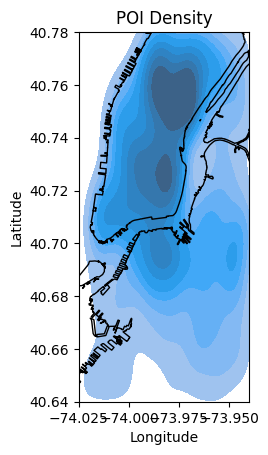

In [184]:
compute_density(poi_gdf, poi_gdf.geometry.x, poi_gdf.geometry.y, 'POI Density', save_gdf=True)

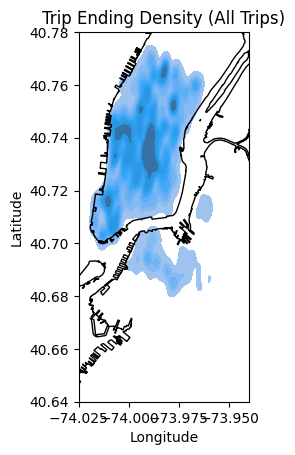

In [185]:
compute_density(city_bike_data, 'end station longitude', 'end station latitude', 'Trip Ending Density (All Trips)', save_gdf=True)

Visually it looks like there is some relationship between the density of points of interest and the density of trips.

In [ ]:
trip_geometry = [Point(xy) for xy in zip(city_bike_data['end station longitude'], city_bike_data['end station latitude'])]
trips = gpd.GeoDataFrame(city_bike_data, geometry=trip_geometry, crs = gdf.crs)

Now that we have computed these densities, we want to know if the density of points of interest can be used to predict the number of trip destinations. We first try simple linear regression as a baseline.

In [191]:
# Create grid of evenly distributed points
bandwidth = 1000
xmin, ymin, xmax, ymax = trips.total_bounds

xcoords = np.arange(xmin, xmax, bandwidth/1110000)
ycoords = np.arange(ymin, ymax, bandwidth/1110000)
X, Y = np.meshgrid(xcoords, ycoords)
kernels = np.vstack([X.ravel(), Y.ravel()])
grid_geometry = [Point(x, y) for y in ycoords for x in xcoords]
grid_gdf = gpd.GeoDataFrame(geometry=grid_geometry)

# KDE for POIs
poi_coords = np.column_stack((poi_gdf.geometry.x, poi_gdf.geometry.y))
poi_kernel = gaussian_kde(poi_coords.T, bw_method=bandwidth/1110000)
poi_dens = np.reshape(poi_kernel(kernels).T, X.shape)

# KDE for trips
trip_coords = np.column_stack((trips.geometry.x, trips.geometry.y))
trip_kernel = gaussian_kde(trip_coords.T)
trip_densities = np.reshape(trip_kernel(kernels).T, X.shape)

In [193]:
X = poi_dens.reshape(-1,1)
y = trip_densities.ravel()

# perform linear regression
lm = LinearRegression()
lm.fit(X, y)
y_pred_lm = lm.predict(X)

print('Coefficients:', lm.coef_)
print('Intercept:', lm.intercept_)
print('R-squared:', lm.score(X, y))

Coefficients: [0.00466447]
Intercept: 116.49965505858762
R-squared: 0.0012296500691064693


Text(0.5, 1.0, 'Predicted (LM)')

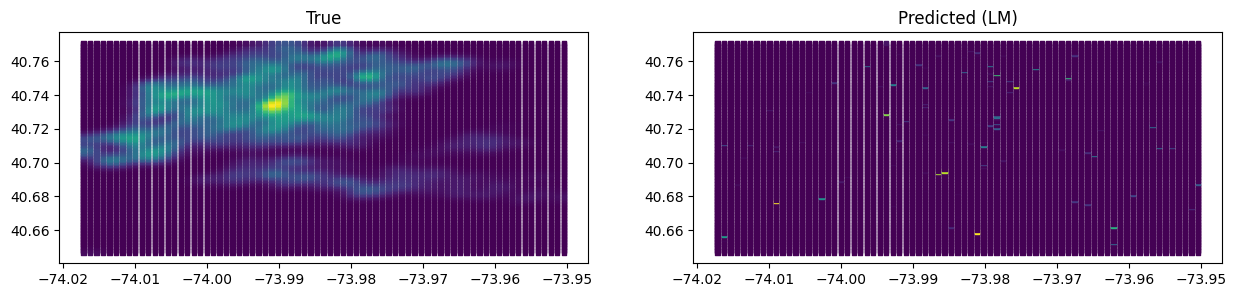

In [194]:
import matplotlib.pyplot as plt
import torch

c = torch.tensor(np.stack([grid_gdf.geometry.x.values.reshape(-1),grid_gdf.geometry.y.values.reshape(-1)],axis=1))

fig, ax = plt.subplots(1,2, figsize=(15, 3))
ax[0].scatter(c[:,0], c[:,1], c=y.reshape(-1), cmap='viridis',marker="s",s=10)
ax[0].set_title('True')
ax[1].scatter(c[:,0], c[:,1], c=y_pred_lm.reshape(-1), cmap='viridis',marker="s",s=10)
ax[1].set_title('Predicted (LM)')

Simple linear regression performs poorly. Now we try a graph neural network which should be able to learn the spatial component of the data.

In [ ]:
from torch_geometric.nn import knn_graph
from torch_geometric.data import Data
from torch_geometric.nn import GCNConv, GATConv, SAGEConv
import torch
import torch.nn as nn
import torch.utils.data
import torch.nn.functional as F

c = torch.tensor(np.stack([grid_gdf.geometry.x.values.reshape(-1),grid_gdf.geometry.y.values.reshape(-1)],axis=1))

X = torch.tensor(X)
y = torch.tensor(y)

y = F.normalize(y,dim=0)
X = F.normalize(X,dim=1)

k = 5
edge_index = knn_graph(c, k=k, loop=False) #represent our data as a graph with edges between nearby points.
graph_data = Data(x=X, y=y, edge_index=edge_index, pos=c)

In [ ]:
class GCN(nn.Module):
    """
        A simple GCN with two convolutional layers
    """
    def __init__(self, num_features_in=3, num_features_out=1, hidden_dim=32, dropout=False):
        super(GCN, self).__init__()
        self.conv1 = GCNConv(num_features_in, hidden_dim)
        self.conv2 = GCNConv(hidden_dim, hidden_dim)
        self.fc = nn.Linear(hidden_dim, num_features_out)
        self.dropout = dropout

    def forward(self, x, edge_index):
        x = x.float()
        h1 = F.relu(self.conv1(x, edge_index))
        if self.dropout:
          h1 = F.dropout(h1, training=self.training)
        h2 = F.relu(self.conv2(h1, edge_index))
        if self.dropout:
          h2 = F.dropout(h2, training=self.training)
        output = self.fc(h2)
        return output

In [ ]:
lr = 1e-3
n_epochs = 10000
print_freq = 1000

model = GCN(num_features_in=3, num_features_out=1, hidden_dim=32, dropout=False)
loss_fun = nn.MSELoss()
optimizer = torch.optim.AdamW(model.parameters(), lr=lr)

if 'range' in globals(): #Delete range from earlier
  del range

In [ ]:
it_counts = 0
for epoch in range(n_epochs):
  it_counts += 1
  model.train()
  out = model(graph_data.x.float(), graph_data.edge_index)
  optimizer.zero_grad()
  loss = loss_fun(graph_data.y.float().reshape(-1), out.reshape(-1))
  loss.backward()
  optimizer.step()
  if it_counts % print_freq == 0:
    print('Loss:', loss.item())

In [ ]:
from sklearn.metrics import r2_score

with torch.no_grad():
  model.eval()
  y_pred_gnn = model(graph_data.x.float(), graph_data.edge_index)

gnn_r2 = r2_score(graph_data.y, y_pred_gnn)
print("GNN R-squared:", gnn_r2)